In [2]:
# We need to join the upper directory in order to access the local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter1d

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

In [3]:
from pytdoa.geodesy.geodesy import SPEED_OF_LIGHT

In [5]:
fs = 92.16e6
cij_meas = np.array([21.64, 14.84, 6.79])

In [6]:
description = pd.read_csv('tdoa_5g_loc/setup/description.csv')

In [7]:
def process_positions(filename):
    # gNB and UE parsing
    with open(filename) as f:
        setup_string = f.readlines()

    for line in setup_string:
        elem = line.split(" ")

        if elem[0] == 'gnb0':
            posxy = elem[1].replace('(','').replace(')','').replace('\n','').split(",")
            gnb0 = [float(posxy[0]),float(posxy[1])]
        elif elem[0] == 'gnb1':
            posxy = elem[1].replace('(','').replace(')','').replace('\n','').split(",")
            gnb1 = [float(posxy[0]),float(posxy[1])]
        elif elem[0] == 'gnb2':
            posxy = elem[1].replace('(','').replace(')','').replace('\n','').split(",")
            gnb2 = [float(posxy[0]),float(posxy[1])]
        elif elem[0] == 'ue':
            posxy = elem[1].replace('(','').replace(')','').replace('\n','').split(",")
            ue = [float(posxy[0]),float(posxy[1])]

    # Offset calculation
    gnb = np.vstack((gnb0,gnb1,gnb2))
    ue = np.array(ue)

    return (gnb, ue)

## Experiments 3-13 (excluding 4)

In [8]:
experiments = np.array([3,5,6,7,8,9,10,11,12,13])
oversample = 16

In [9]:
cij_df = pd.DataFrame(columns=['c12','c13','c23','calibrated','exp','time'])
N = 4

for experiment in experiments:
    columns = ['0','gnb','1','toa','2','3','4','5','6']

    # TOA file parsing
    toa = pd.read_csv(f'tdoa_5g_loc/setup/exp{experiment}/prs_rx_{experiment}', names=columns, sep="s+|;|:|,", header=None, engine='python')
    toa = toa[['gnb','toa']]

    toa_0 = toa.loc[toa['gnb'] == 0,:]['toa'].to_numpy()
    toa_1 = toa.loc[toa['gnb'] == 1,:]['toa'].to_numpy()
    toa_2 = toa.loc[toa['gnb'] == 2,:]['toa'].to_numpy()
    toa_a = np.array([toa_0, toa_1, toa_2], dtype=float)
    toa_av = uniform_filter1d(toa_a, size=N, mode='wrap', axis=1)

    # Uncalibrated
    tdoa_a = np.array([toa_av[0,:] - toa_av[1,:], toa_av[0,:] - toa_av[2,:], toa_av[1,:] - toa_av[2,:]])
    ddoa_a = (tdoa_a / (fs * oversample) * SPEED_OF_LIGHT)

    # Calibrated
    tdoa_c = np.array([toa_av[0,:] - toa_av[1,:] + cij_meas[0], toa_av[0,:] - toa_av[2,:] + cij_meas[1], toa_av[1,:] - toa_av[2,:] + cij_meas[2]])
    ddoa_c = (tdoa_c / (fs * oversample) * SPEED_OF_LIGHT)

    (gnb, ue) = process_positions(f'{os.getcwd()}{os.sep}tdoa_5g_loc/setup/exp{experiment}/note.txt')
    doa_th = np.sqrt(np.sum(np.square(ue - gnb), axis=1))
    ddoa_th = np.array([doa_th[0]-doa_th[1], doa_th[0]-doa_th[2], doa_th[1]-doa_th[2]])
    cij_ns = ((ddoa_a - ddoa_th.reshape(-1,1)) / SPEED_OF_LIGHT * 1e9).T
    cij_ns_c = ((ddoa_c - ddoa_th.reshape(-1,1)) / SPEED_OF_LIGHT * 1e9).T

    tmp = pd.DataFrame(cij_ns, columns=['c12','c13','c23'])
    tmp['calibrated'] = 'Uncalibrated'
    tmp['exp'] = experiment

    tmp_c = pd.DataFrame(cij_ns_c, columns=['c12','c13','c23'])
    tmp_c['calibrated'] = 'Calibrated'
    tmp_c['exp'] = experiment

    tmp = pd.concat((tmp, tmp_c),ignore_index=True)

    time = description.loc[description['Number'] == experiment, 'Time'].values[0]
    tmp['time'] = time
    cij_df = pd.concat((cij_df,tmp),ignore_index=True)

cij_df = cij_df.reset_index()

## Plotting

In [10]:
import json

import matplotlib.pyplot as plt
with open("/home/yago_lizarribar/seaborn-styles/ticks.json", "r") as json_stream:
    plot_style = json.load(json_stream)

In [42]:
import scienceplots

plt.style.use(['science','ieee'])
plt.rcParams.update({'figure.dpi': '125'})

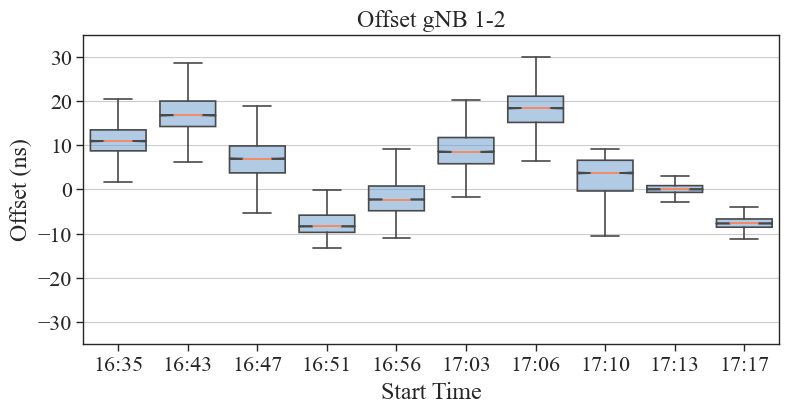

In [22]:
g1, g2 = 2,3
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 4))
f.tight_layout(h_pad=3)
sns.set_theme("paper", plot_style, font_scale=1.8, font='Times New Roman')

cij_df_show = cij_df.loc[cij_df['calibrated']=='Calibrated',:]

sns.boxplot(data=cij_df_show,x='time',y=f'c{g1}{g2}',
    notch=True,
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
    flierprops={"marker": ""},
    ax=ax,)
ax.set(title=f'Offset gNB {g1}-{g2}')
ax.set(xlabel='Start Time')
ax.set(ylabel='Offset (ns)',ylim=(-35,35))
# ax.legend(title='',loc='upper center',ncols=2)

plt.savefig(f'pics/offsets_313{g1}{g2}_calib.pdf', format='pdf', bbox_inches='tight')

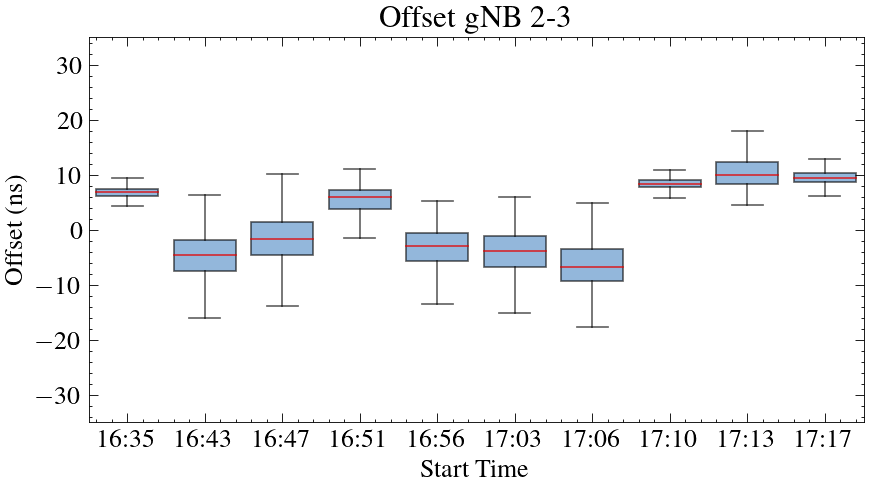

In [94]:
g1, g2 = 2,3
f, ax = plt.subplots(figsize=(8, 4))
plt.rcParams.update({'font.size': 15})

cij_df_show = cij_df.loc[cij_df['calibrated']=='Calibrated',:]

sns.boxplot(data=cij_df_show,x='time',y=f'c{g1}{g2}',
    notch=False,
    boxprops={"color":(.0, .0, .0,.6), "facecolor": (.4, .6, .8, .7),},
    medianprops={"color": (.9, .0, .0,.75)},
    whiskerprops={"color": (.0, .0, .0,.6)},
    capprops={"color": (.0, .0, .0,.6)},
    flierprops={"marker": ""},
    ax=ax,)
ax.set(title=f'Offset gNB {g1}-{g2}')
ax.set(xlabel='Start Time')
ax.set(ylabel='Offset (ns)',ylim=(-35,35))

ax.xaxis.set_tick_params(length=5,)
ax.yaxis.set_tick_params(length=5,)
# ax.legend(title='',loc='upper center',ncols=2)

# plt.savefig(f'pics/offsets_313{g1}{g2}_v2.pdf', format='pdf', bbox_inches='tight')